# Advanced Prompt Engineering - Chain of Thought and Self Consistency
* Notebook by Adam Lang
* Date: 8/12/2024

# Overview
* This notebook contains Advanced Prompt Engineering Techniques mainly **Chain of Thought** and **Self Consistency**.

## Chain of Thought
* Allows models to decompose multi-step problems into intermediate steps.
* This also leads to additional computation for problems that require more reasoning steps.
* Use Cases for Chain of Thought Prompting
1. Enhances Language's Model's Ability
  * CoT can solve complex problems such as math, reasoning and symbolic manipulation.
2. Interpretable window into model's behavior
  * CoT allows for insights into how the model arrived at a specific answer.
  * This also shows opportunities for debugging.
3. Matches Human Capabilities
  * CoT can be applied to various tasks.

### Chain of Thought Prompting Examples

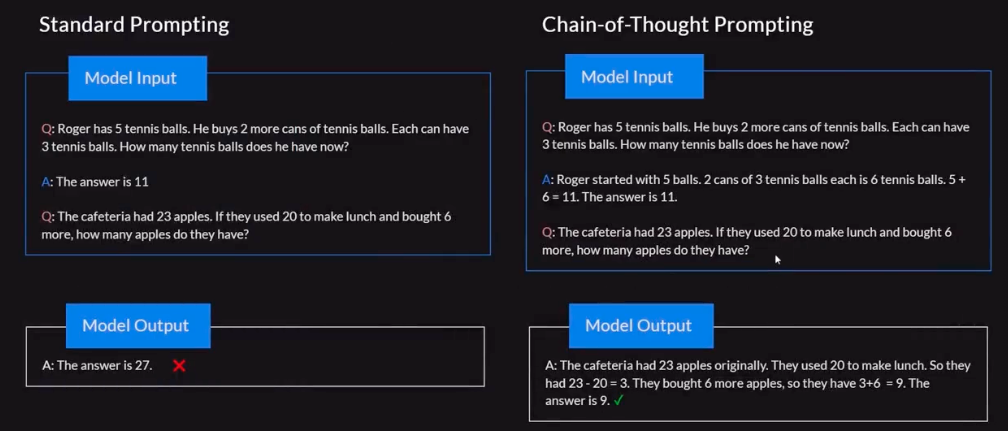

Summary:
* We can see the difference with CoT prompting is that the Answer we give shows how the model should reason to get the answer to the question we gave it.
* Giving the LLM this "reasoning" example allows it to iterate and come up with the correct answer.
* In the first prompt there is no context and no "chain of thought" given to the model thus leaving the door open for hallucinations.

### Pros of Chain of Thought Prompting
1. State of the art accuracy --> surpasses finetuned models with verifier.
2. Applicable to various tasks that require multi-step reasoning.
  * This makes CoT a more versatile approach in various domains and use cases.
3. Enhances interpretability of LLMs by providing insights into the language models reasoning process through **Generated Chains of Thought**
4. CoT prompting is:
   * ready to use
   * cost effective
   * DOES NOT require model fine-tuning!

### Cons of Chain of Thought Prompting
1. Augmenting prompts with thought chains can be **resource intensive!**
2. CoT prompts to not necessarily guarantee results free of errors. Accuracy can be mixed.
3. CoT prompts are most effective in larger models and sometimes less effective in smaller models.

### Resources for CoT Prompting
* Sun et al. 2024. Enhancing Chain-of-Thoughts Prompting with Iterative Bootstrapping in Large Language Models. https://aclanthology.org/2024.findings-naacl.257.pdf
* Wei et al. 2022. Chain-of-Thought Prompting Elicits Reasoning
in Large Language Models. https://arxiv.org/pdf/2201.11903

## Self Consistency Prompting
* Helps LLMs solve complex problems by considering MULTIPLE WAYS to think about a problem --> Then chooses the MOST COMMON solution.

### How does it work?
* **Multi-path Reasoning**
   * Generates and evaluates various reasoning paths choosing the most recurring outcome or results.
* **Confidence Through Consensus**
   * Reliable when different reasoning approaches converge on a single answer.
   * Mimicks human confidence in decision-making.
* **Beyond 'Greedy Decoding'**
   * Surpasses traditional 'greedy decoding' by avoiding pitfalls like repetition and local-optimality issues.

### Comparing Self-Consistency Prompts vs. Chain of Thought Prompting
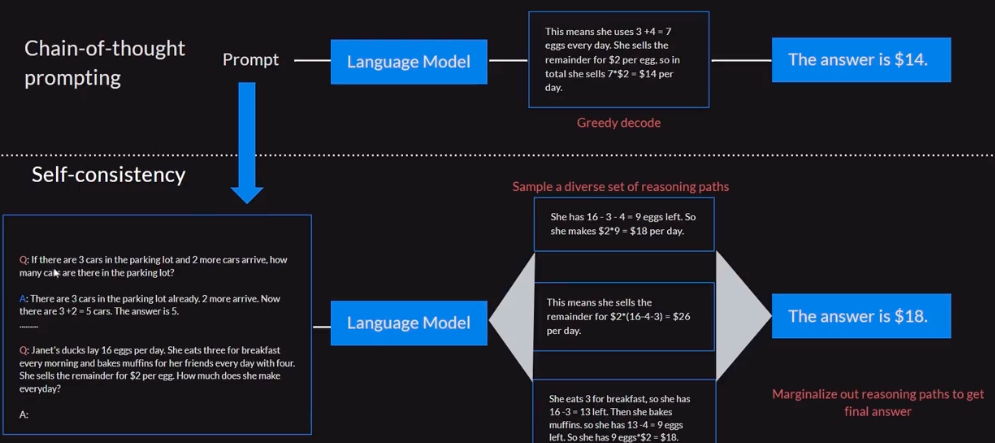



Summary:
* The main differences:
1. Chain of Thought uses **greedy decoding**
2. Self-consistency samples a diverse set of reasoning paths to marginalize the output and get a more "reasonable" consensus answer.
3. We can see that by giving the LLM more than 1 path to take it goes "beyond greedy decoding".



### Pros of Self Consistency Prompting
1. Makes answers more reliable by checking them through multiple paths rather than "greedy decoding" 1 answer.
2. Enforces "how sure" the model is about the final output answer.
3. Simple prompting method
  * Does not need additional model training.
  * Saves time and effort.

### Cons of Self Consistency Prompting
1. Evaluates MULTIPLE solutions requires more processing power and time.
2. Can generate nonsense or incorrect answers if given too many paths to reason with.
3. Does not guarantee correct answers or non-hallucination.

# Self Consistency Prompting - implementation.
* Resources
1. https://visualsummary.substack.com/p/self-consistency-prompting?utm_source=publication-search
2. paper: https://arxiv.org/pdf/2203.11171

In [4]:
!pip install langchain_openai langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 10.1 MB/s eta 0:00:00


In [5]:
## imports

# os
import os

# operator.itemgetter: extracts items from sequences
from operator import itemgetter

# langchain_openai.ChatOpenAI - llm integration
from langchain_openai import ChatOpenAI

# langchain.prompts.PromptTemplate - predefined templates
from langchain.prompts import PromptTemplate

# langchain.schema.StrOutputParser - parses string outputs into structured output
from langchain.schema import StrOutputParser

# langchain.schema.runnable.RunnablePassThrough - wraps runnable objects for easy execution
from langchain.schema.runnable import RunnablePassthrough

#ipython display in notebooks
from IPython.display import display, Markdown

In [6]:
## setup openai and dependencies
from getpass import getpass

OPENAI_KEY = getpass('Enter your openai key: ')

Enter your openai key: ··········


In [7]:
## setup open ai environment
os.environ['OPENAI_API_KEY'] = OPENAI_KEY

## Prompt Experiments

In [8]:
## define a question about apple quantities and usage
question = """The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples to they have?"""

## Give context for answer questions -- emphasize detail and reasoning
context = """Answer questions showing the full math and reasoning. Follow the pattern in the example."""

## Example problem-solving scenario with math calculations
one_shot_example = """Example
Q: Andy has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?

A: Andy started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5 + 6 = 11. The answer is 11.

Q: """

In [9]:
## create a planning pipeline - PromptTemplate, ChatOpenAI, StrOutputParser, RunnablePassthrough
planner = (

           # combine context and example with input placeholder for dynamic prompt creation
           PromptTemplate.from_template(context + one_shot_example + " {input}")

           # Process combined template through ChatOpenAI for generative output
           | ChatOpenAI() #we are using LCEL pipe

           # parse generated text into structured data
           | StrOutputParser() # LCEL pipe

           # Wrap parsed output in RunnablePassThrough object for further processing
           | {"base_response": RunnablePassthrough()} # LCEL pipe


)

## Self-Consistency Method
* First we generate `answer_1` which is 1 thought process to get an answer.
* Then we generate `answer_2` which is another thought process to get another answer.

In [10]:
## generate structured response using PromptTemplate, ChatOpenAI, and StrOutputParser
answer_1 = (

            # start with base response template followed by "A: "
            PromptTemplate.from_template("{base_response} A: ")

            # Use ChatOpenAI with temp set to 0 for deterministic output
            | ChatOpenAI(temperature=0)

            # Parse generated text into structured output
            | StrOutputParser()
)

Below we will vary the `temperature` setting to vary the output.

In [11]:
# Generate another structured response
answer_2 = (
            # start with base response template followed by "A: "
            PromptTemplate.from_template("{base_response} A: ")

            # Use ChatOpenAI - vary temperature setting to 0.1 for deterministic response
            | ChatOpenAI(temperature=0.1)

            # Parse generated output into structured output
            | StrOutputParser()
)

In [12]:
# Generate another structured response
answer_3 = (
            # start with base response template followed by "A: "
            PromptTemplate.from_template("{base_response} A: ")

            # use ChatOpenAI with temp varied to 0.7 to vary output
            | ChatOpenAI(temperature=0.7)

            # Parse generated text into structured output
            | StrOutputParser()
)

Format Final response

In [13]:
## final responder setup for formatting and displaying results in markdown
final_responder = (

                   # Template for outputting results in markdown
                   PromptTemplate.from_template(
                       """Output all the final results in this markdown format: Result 1: {results_1} \n Result 2:{results_2} \n Result 3:
                       {results_3}"""
                   )

                   # Process template through ChatOpenAI for text generation
                   | ChatOpenAI()

                   # Parse generated text into structured output
                   | StrOutputParser()
)

Chain together all answers for final output

In [14]:
# chain together components for response
chain = (

         # initial planning stage
         planner

         # map results and original response to specific variables
         | {
             "results_1": answer_1,
             "results_2": answer_2,
             "results_3": answer_3,
             "original_response": itemgetter("base_response"),
         }

         # finalize response with formatting and display
         | final_responder
)

In [15]:
# invoke response chain with given input question
answers = chain.invoke({"input": question})

# display generated answers in markdown format
display(Markdown(answers))

Result 1: The cafeteria now has 9 apples. 

Result 2: The cafeteria now has 9 apples. 

Result 3: The cafeteria now has 9 apples.

Summary:
* Thus we can see using the 3 different prompting approaches coupled into "Self Consistency" we got the same answer 3 times.
* This is more cumbersome but is a method to verify output results are correct.